#### CIFAR10 Attack Notebook

In [3]:
%%capture installation
import os
import argparse
import datetime

import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from typing import Callable, Tuple, Dict
from pathlib import Path
import pytorch_lightning as pl
from torch import nn

from dataloader import load_mnist
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CelebAAutoencoder, CIFAR10Autoencoder, CIFAR10VAE,
                                CIFAR10LightningAutoencoder)
from models.classifier import (CelebAClassifier, CIFAR10Classifier,
                                MNISTClassifier)

from attacks import ATTACK_MAPPINGS
from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

2022-12-26 19:53:33.206455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-26 19:53:33.344933: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-26 19:53:33.377453: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-26 19:53:34.199397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [4]:
class Args:
    batch_size = 100
    attack_name = "hopskipjump"
    device  = "cuda"
    model_name = "cifar10_cnn_1"
    ae_name = "cnn_256"
    plot = False
    plot_dir = "./plots"
    # kwargs = {"batch_size": 32, "nb_grads": 5, "epsilon": 1e-05} # deepfool
    # kwargs = {"eps": 0.1} # pgd and fgsm
    kwargs = {}

args = Args()

In [5]:
attack_name = ATTACK_MAPPINGS.get(args.attack_name)
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")
_, _, test_dataloader = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
print(f"Loaded dataloader!!!!!")

# ae = CIFAR10LightningAutoencoder()
# autoencoder_model = ae.from_pretrained('cifar10-resnet18').to(config["device"]).eval()

Working on the dataset: cifar10!!!!!
['img', 'visualise_tsne.py', 'visualise_logs.ipynb', 'mnist_attack.ipynb', 'semantic_optimization_attack.ipynb', 'cifar10_attack_uq.ipynb', 'LICENSE', 'objects', 'dataset.py', 'visualise_tsne.ipynb', 'defences', 'plots', 'attack_main.py', 'dataloader.py', 'utils.py', '.gitignore', 'celeba_attack.ipynb', 'lightning_logs', 'cifar10_attack.ipynb', '.git', '.DS_Store', '__pycache__', 'README.md', 'plot_attack.py', 'attacks', 'comments.txt', 'configs', 'models']
./lightning_logs/cifar10_classifier/checkpoints/epoch=49-step=35150.ckpt


/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/sweta/gpu-top/Semantic-Preserving-Adversarial-Attack/models/autoencoder.py:709: UnderReviewWarning: The feature AE is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  super().__init__(input_heig

Loaded classifier and autoencoder models in eval mode!!!!!
Files already downloaded and verified
Files already downloaded and verified
Loaded dataloader!!!!!


In [6]:
x, y, z = get_xyz(args, autoencoder_model, test_dataloader)
    
config["latent_shape"] = args.ae_name.split('_')[-1]
classifier, hybrid_classifier, accuracy = hybridize(x, y, z, 
                                                    config, classifier_model, autoencoder_model)

# Perform attack
conditionals = {
    "calculate_original": False,
    "is_class_constrained": False
}
result: Dict = execute_attack(config, attack_name, x, y, z, classifier, hybrid_classifier, autoencoder_model, args.kwargs, conditionals)

torch.Size([100, 256])
Accuracy on benign test examples: 87.0%
Accuracy on benign test examples(from reconstructed): 71.0%


UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U21'), dtype('<U21')) -> None

In [5]:
if conditionals["calculate_original"]:
    x_adv = result[attack_name.__name__]["x_adv"]
    delta_x = result[attack_name.__name__]["delta_x"]

x_hat_adv  = result[attack_name.__name__]["x_hat_adv"]
modf_x_adv = result[attack_name.__name__]["modf_x_adv"]

# noises
delta_x_hat = result[attack_name.__name__]["delta_x_hat"]

import torchvision
def plot_images(images):
    plt.figure(figsize=(20, 2))
    images = torch.Tensor(images).reshape(-1, 3, 32, 32)
    # i = 1
    # for image in images:
    #     plt.subplot(5, 5, i, xticks=[], yticks=[])
    #     plt.imshow(np.transpose(image, (1, 2, 0)))
    #     i = i + 1

    #     if i == 26:
    #         break
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

start = 22
end   = 32

In [6]:
if conditionals["calculate_original"]:
    plot_images(x_adv[start: end])

In [7]:
if conditionals["calculate_original"]:
    plot_images(delta_x[start: end])

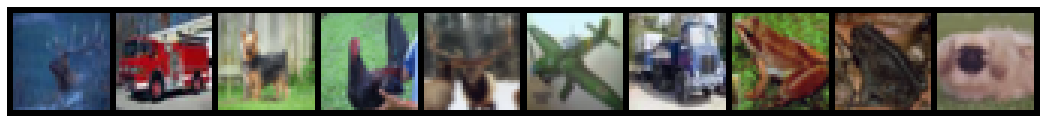

In [8]:
plot_images(x[1][start: end])

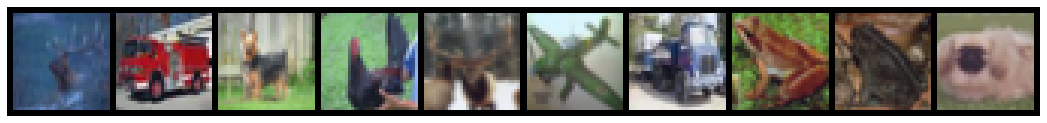

In [9]:
plot_images(modf_x_adv[start: end])

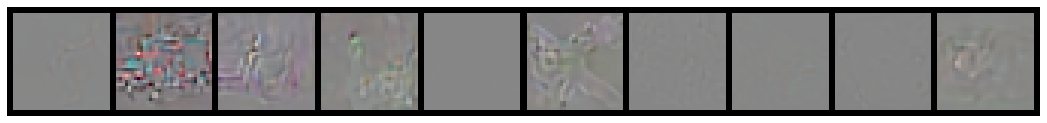

In [10]:
plot_images(delta_x_hat[start: end])

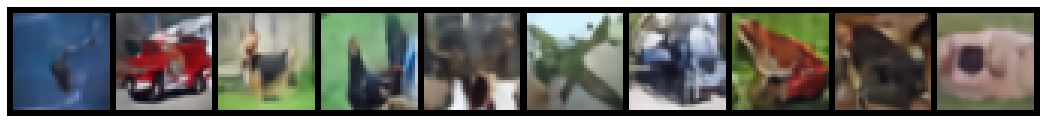

In [11]:
plot_images(x_hat_adv[start: end])

#### Finding Border

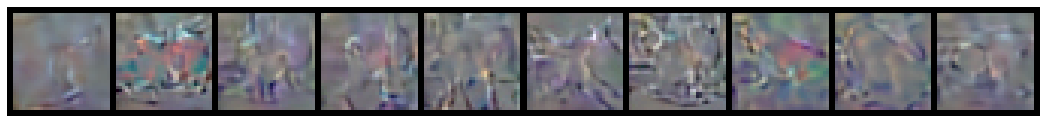

In [82]:
z = autoencoder_model.get_z(x[0][start: end])
noisy_z = z + 0.0001
x_hat = autoencoder_model.get_x_hat(z)
noisy_x_hat = autoencoder_model.get_x_hat(noisy_z)
delta = noisy_x_hat - x_hat
plot_images(delta.cpu().detach())

##### LPIPS

In [ ]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores

# LPIPS between original and original attacks
import torch
img0 = torch.Tensor(orig_attk_images) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = x[0].detach().cpu()
d = loss_fn_alex(img0, img1)
print(d.flatten())

In [60]:
# LPIPS between original and modified attacks
import torch
img0 = torch.Tensor(modf_attk_images) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = x[0].detach().cpu()
d = loss_fn_alex(img0, img1)
print(d.flatten())

NameError: name 'modf_attk_images' is not defined

In [ ]:
from robustbench.utils import load_model

model = load_model(model_name='Carmon2019Unlabeled', dataset='cifar10', threat_model='Linf')

In [25]:
import numpy as np
from art.estimators.classification import PyTorchClassifier

criterion = nn.CrossEntropyLoss()
classifier = PyTorchClassifier( 
    model=model,
    clip_values=(0, 1),
    loss=criterion,
    # optimizer=optimizer,
    input_shape=(32, 32),
    nb_classes=10,
)

predictions = classifier.predict(orig_attk_images)
accuracy = np.sum(np.argmax(predictions, axis=-1) == y[1]) / len(y[1])
accuracy

0.7